<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2023_hands_on/blob/main/Week07_Image_Classification_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 07

## Introduction
From this week, you will be working on the image classification competition. Your mission is to implement a deep neural network model capable of classifying three different kinds of noodles: spaghetti, ramen, and udon, with higher accuracy.

This notebook contains example code for the competition. To improve accuracy, you may need to apply various techniques you've learned.

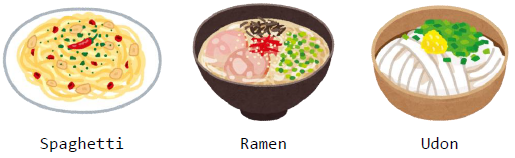

## About Competition




### Kaggle


*   The competition is held on the Kaggle platform.
*   Please join the competition from the invitation link on our Teams channel.



### Timeline
*   2023/10/19 --- Start Competition
*   2023/11/7 22:59 (Taiwan), 23:59 (Japan) --- Submission Deadline
*   2023/11/8 8:00 (Taiwan), 9:00(Japan) --- Final Leaderboard Release

### Rules
*   Each student can have only one account for the competition.
*   Change your Kaggle team name to "team id + your name", for example "9 Naoya".
*   Each student can submit their own predictions up to 10 times per day.
*   Submissions are evaluated based on the accuracy. The higher the better.
*   The highest accuracy of your team members will be your final team score.
*   Before the submission deadline, the leaderboard is calculated with 20% of the test dataset. The final results will be based on the other 80%.
*   Do not cheat!



## Data Preparation

### GPU

Please make sure your runtime type is set to GPU (cuda).

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### General Packages

Let's import some general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import gdown

### Download Data

Unlike the CIFAR10 dataset, the data we will be using here consists of regular JPEG files. Therefore, we need to prepare the dataset for PyTorch to process.

The noodle image data can be downloaded using the code below. Once the download is complete, you will find 'noodles_dataset.zip' in the Files tab on the left side.

In [3]:
gdown.download('https://drive.google.com/uc?id=1-JwyQvDp1k9FEwf6_Z1553rh0hCtOewF', 'noodles_dataset_3k.zip', quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1-JwyQvDp1k9FEwf6_Z1553rh0hCtOewF
To: /content/noodles_dataset_3k.zip
100%|██████████| 142M/142M [00:01<00:00, 124MB/s]


'noodles_dataset_3k.zip'

Then unzip `noodles_dataset.zip` then you will find `noodles_dataset` directory in the Files tab.

In [4]:
! unzip noodles_dataset_3k.zip > /dev/null 2>&1

In the `noodles_dataset` directory, you will find two main directories named `train` and `test`. Within the `train` directory, there are subdirectories labeled `0_spaghetti`, `1_ramen`, and `2_udon`, each containing respective images of spaghetti, ramen, and udon. Inside the `test` directory, there is a subdirectory named `unknown`, which contains spaghetti, ramen, and udon images mixed together in a random order.

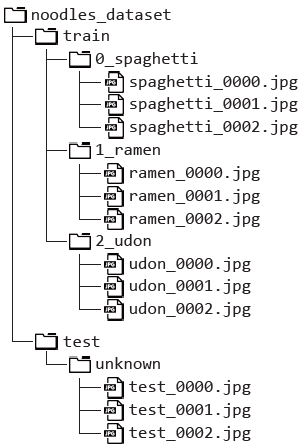

Let's check how many image data we have.

In [5]:
for subdir in ["train", "test"]:
    print(subdir)
    subsubdirs = sorted(os.listdir(os.path.join("noodles_dataset_3k", subdir)))
    for subsubdir in subsubdirs:
        filenames = os.listdir(os.path.join("noodles_dataset_3k", subdir, subsubdir))
        print("---", subsubdir, ":", len(filenames))

train
--- 0_spaghetti : 1000
--- 1_ramen : 1000
--- 2_udon : 1000
test
--- unknown : 1000


### Create Dataset
To create PyTorch datasets with this tree-structured directory format, we can use `torchvision.datasets.ImageFolder` class.

In [6]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root="noodles_dataset_3k/train")
test_dataset = ImageFolder(root="noodles_dataset_3k/test")

print("train_dataset:", len(train_dataset))
print("test_dataset:", len(test_dataset))

train_dataset: 3000
test_dataset: 1000


Let's take a look at some spaghetti data within the `train_dataset`.

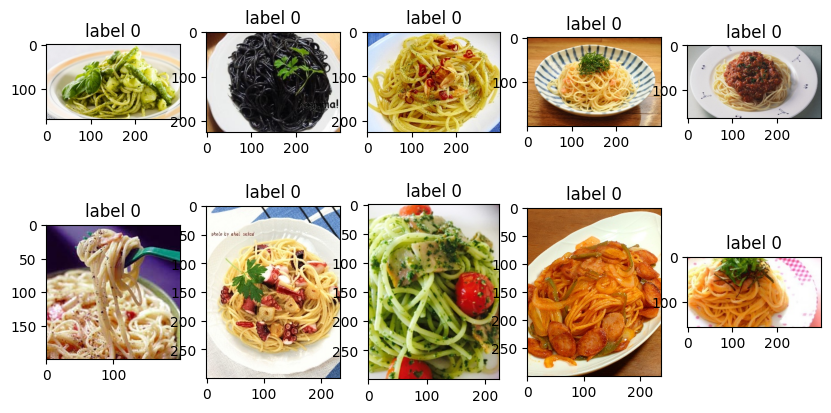

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

Let's take a look at some ramen data within the `train_dataset`.

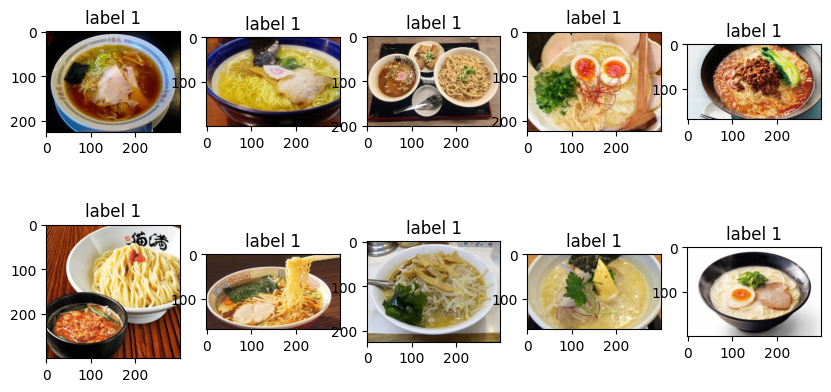

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i+1000]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

Let's take a look at some udon data within the `train_dataset`.

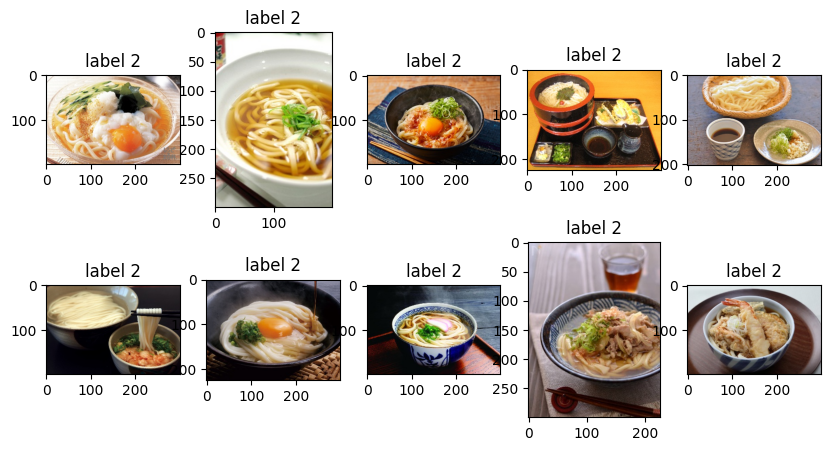

In [9]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i+2000]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

As you can see above, spaghetti, ramen, and udon images are labeled as "0", "1", and "2", respectively.

This labeling is automatically assigned based on the directory names within the `train` directory specified in `ImageFolder`. You can check the assigned label numbers as demonstrated below.

In [10]:
train_dataset.class_to_idx

{'0_spaghetti': 0, '1_ramen': 1, '2_udon': 2}

Here, we are creating a dictionary to map the class names.

In [11]:
classnames = {0:"spaghetti", 1:"ramen", 2:"udon"}
classnames

{0: 'spaghetti', 1: 'ramen', 2: 'udon'}

Let's take a look at some data within the `test_dataset`.

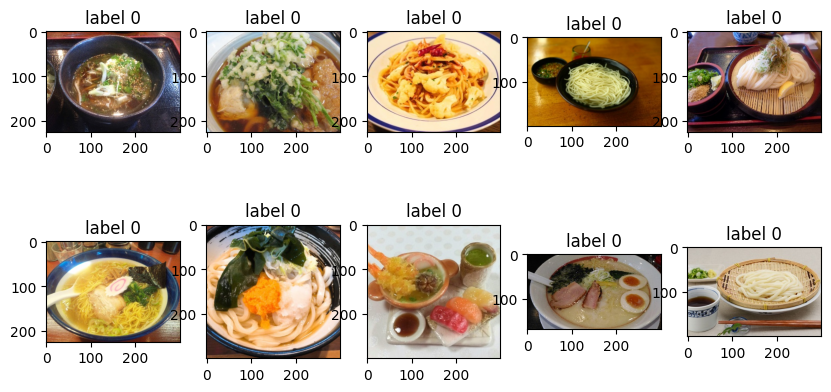

In [12]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = test_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}")

Since there is only one subdirectory named `unknown` in the `test` directory, all the images within it are labeled as `0`.

In [13]:
test_dataset.class_to_idx

{'unknown': 0}

To feed image data into a PyTorch model, it's essential that all image data shares the same dimensions. In this step, we resize all the image data to 96x96 pixels and convert it to the `torch.tensor` format. Additionally, you have the option to apply further preprocessing techniques such as data standardization and data augmentation at this stage.

In [24]:
from torchvision.transforms import v2

train_dataset = ImageFolder(root="noodles_dataset_3k/train",
                            transform=v2.Compose([
                                v2.Resize((96, 96)),
                                v2.ToTensor()
                                ])
                       )

test_dataset = ImageFolder(root="noodles_dataset_3k/test",
                           transform=v2.Compose([
                                v2.Resize((96, 96)),
                                v2.ToTensor()
                                ])
                      )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


### Data Splitting

Since all of the test dataset is labeled as `0`, which means they are not labeled correctly, we cannot use them to evaluate the trained model.

Therefore, we need to create another dataset for evaluation, commonly known as the validation dataset. Typically, the validation dataset is created by splitting the original training dataset. In this case, we are splitting the train_dataset into two datasets: `valid_dataset` and a new `train_dataset`.

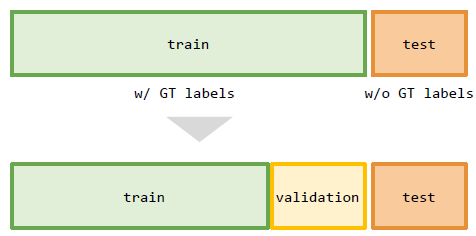

In [25]:
from torch.utils.data import random_split

n_samples = len(train_dataset)
train_size = int(n_samples * 0.5)    # 50% will be training data
valid_size = n_samples - train_size  # 50% will be validation data

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("train data", len(train_dataset))
print("validation data", len(valid_dataset))

train data 1500
validation data 1500


### DataLoader

Then we create the dataloaders for the training, validation and test dataset.

In [26]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

## Model Building

### Model Architecture

You can use any kind of models you want.

In [27]:
import torch.nn as nn

# define a class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change

        # define a network module named "features"
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # define a network module named "junction"
        self.junction = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(output_size=512)
        )

        # define a network module named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=3)
        )

    # Instance method
    def forward(self, x):   # do not change
        x = self.features(x)
        x = self.junction(x)
        x = self.classifier(x)
        return x

model = Model()    # construct an instance of the Model class
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (junction): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): AdaptiveAvgPool1d(output_size=512)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)


## Training

### Training Loop







In [29]:
import torch.optim as optim

model = Model().to(device)                             # load model to GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-2)    # set optimizer
epochs = 3

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    valid_correct_count = 0
    valid_accuracy = 0
    valid_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(valid_loader)
        pbar.set_description("Valid")

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            valid_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            valid_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    valid_accuracy = valid_correct_count.item()/len(valid_dataset)   # determin accuracy for test data
    train_loss = train_loss/len(train_loader)       # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)       # determin loss for validation data

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)

    print("---------------------")

Epoch 1/3


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train: Accuracy=0.383 Loss=1.245, Valid: Accuracy=0.475 Loss=1.024
---------------------
Epoch 2/3


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train: Accuracy=0.497 Loss=0.996, Valid: Accuracy=0.565 Loss=0.960
---------------------
Epoch 3/3


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Train: Accuracy=0.546 Loss=0.941, Valid: Accuracy=0.562 Loss=0.951
---------------------


### Learning Curves

Let's visualize the accuracy and the loss curves for training and validation data.

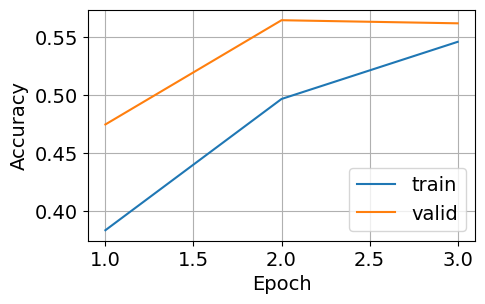

In [30]:
plt.figure(figsize=(5, 3))
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

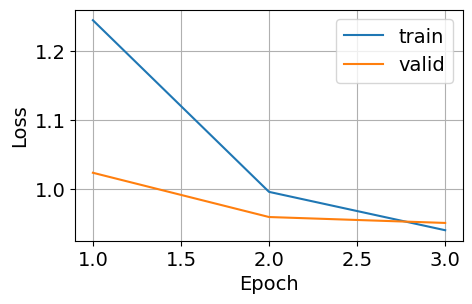

In [31]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

You may want to perform some evaluations with the validation data.

## Submission

### Make Submission File

In [32]:
#####################
##  DO NOT CHANGE  ##
#####################

p_label_all = np.array([])

with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        p_batch = model(x_batch)
        p_batch_label = torch.argmax(p_batch, dim=1)
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())

p_label_all = p_label_all.astype("uint8")
print(p_label_all)

df_submit = pd.DataFrame()
df_submit["ID"] = np.arange(1000)
df_submit["Target"] = p_label_all

df_submit.to_csv("your_submission.csv", index = False)

df_submit

[2 2 0 2 2 1 2 0 1 2 0 0 0 2 2 1 1 1 2 2 0 2 2 0 2 1 2 0 0 1 1 0 2 2 2 2 1
 0 2 1 1 1 2 2 2 1 1 1 1 2 2 1 2 1 0 0 2 2 1 2 1 2 1 0 2 0 1 0 1 1 1 1 2 1
 1 0 1 0 2 2 2 2 2 2 2 0 2 2 1 2 2 2 1 2 1 1 0 1 2 2 1 1 2 1 2 2 2 0 2 1 1
 2 2 1 0 0 2 2 0 2 0 2 2 2 2 2 0 2 2 0 2 0 2 1 2 1 1 2 1 2 2 1 2 2 2 2 2 1
 2 1 0 0 1 0 2 1 2 0 2 0 2 1 2 0 0 2 0 1 1 0 2 2 2 0 1 1 2 2 1 0 2 2 2 0 2
 0 1 1 0 1 2 2 1 2 1 0 1 1 2 1 2 2 2 1 2 2 2 1 2 0 0 2 2 0 2 0 0 0 2 0 0 1
 2 1 1 2 2 0 2 1 0 0 1 2 0 2 1 1 2 0 2 1 1 2 0 2 2 1 0 1 2 2 2 2 2 1 1 0 2
 1 2 1 2 2 1 1 1 0 1 1 2 0 1 2 1 1 2 2 1 2 2 1 1 1 0 2 0 1 2 1 1 2 1 1 2 2
 1 2 2 2 0 1 0 2 2 0 1 1 2 0 0 0 2 2 2 2 2 2 2 1 0 2 1 2 1 1 1 2 2 2 2 2 2
 1 0 0 2 2 2 1 1 1 2 1 1 0 1 2 2 1 0 0 2 1 0 2 2 1 1 2 2 2 1 2 0 0 0 2 2 2
 2 2 1 0 2 1 1 0 1 2 2 2 0 0 2 2 2 2 0 2 0 2 2 2 1 1 1 0 0 1 1 1 0 0 1 0 1
 1 1 2 0 2 0 0 2 0 1 2 0 1 0 0 1 0 2 2 2 1 2 1 1 2 1 2 1 1 0 1 2 2 0 1 2 1
 1 1 0 1 1 0 1 1 0 0 2 1 2 2 0 0 2 0 1 0 2 2 0 0 2 1 2 1 2 2 1 2 1 2 1 2 1
 2 0 2 2 2 2 2 1 0 2 2 1 

,ID,Target
0,0,2
1,1,2
2,2,0
3,3,2
4,4,2
...,...,...
995,995,0
996,996,0
997,997,2
998,998,2


### Submition from Kaggle
You can now download `your_submission.csv` file from the 'Files' tab, and proceed to submit it on our competition page on Kaggle

## Conclusion

That's it for this week. Try your best for the image classification competition!